In [1]:
import matplotlib.pyplot as plt
import numpy as np
from data_processors.gridworld_rbf import GWDataProcessorRBF
from data_processors.utils import gauss

In [2]:
# Define a plotting function
def plot_rbf_features(processor: GWDataProcessorRBF, amplitude: float = 1.0):
    """
    Plots the RBF features along x and y dimensions using the given data processor.
    Args:
        processor (GWDataProcessorRBF): An instance of the GWDataProcessorRBF class
        amplitude (float): Amplitude factor to adjust the height of the Gaussians
    """
    grid_size = processor.means[-1]  # The size of the grid
    x_vals = np.linspace(0, grid_size, 100)  # Generate 100 points along each dimension
    y_vals = np.linspace(0, grid_size, 100)

    # Compute RBF features for x and y
    rbf_features_x = np.zeros((processor.num_basis, len(x_vals)))
    rbf_features_y = np.zeros((processor.num_basis, len(y_vals)))

    for i, mean in enumerate(processor.means):
        rbf_features_x[i, :] = [amplitude * gauss(x, mean, processor.std_dev) for x in x_vals]
        rbf_features_y[i, :] = [amplitude * gauss(y, mean, processor.std_dev) for y in y_vals]

    # Plot the RBF features along the x dimension
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    for i in range(processor.num_basis):
        ax[0].plot(x_vals, rbf_features_x[i, :], label=f'RBF Center {i + 1}')
    ax[0].set_title('RBF Features along X Dimension')
    ax[0].set_xlabel('X Position')
    ax[0].set_ylabel('RBF Activation')
    ax[0].legend()
    ax[0].grid()

    # Plot the RBF features along the y dimension
    for i in range(processor.num_basis):
        ax[1].plot(y_vals, rbf_features_y[i, :], label=f'RBF Center {i + 1}')
    ax[1].set_title('RBF Features along Y Dimension')
    ax[1].set_xlabel('Y Position')
    ax[1].set_ylabel('RBF Activation')
    ax[1].legend()
    ax[1].grid()

    plt.tight_layout()
    display(fig)
    plt.close(fig)

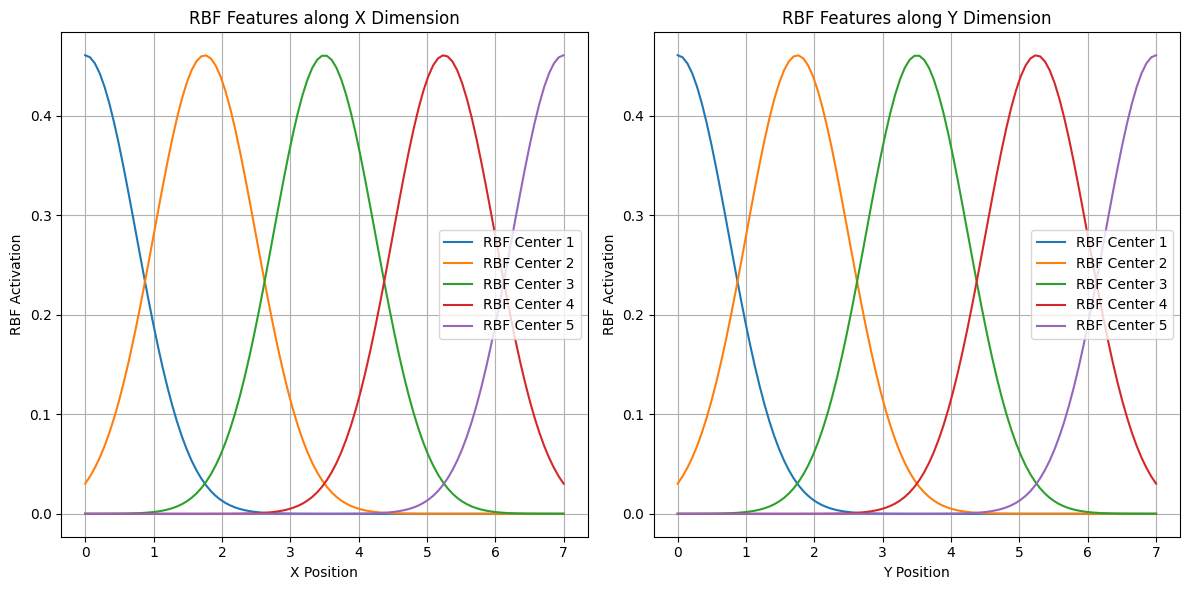

In [11]:
# Example usage:
num_basis = 5
grid_size = 7
std_dev = 0.75
amplitude = 1

# Create an instance of the RBF processor
rbf_processor = GWDataProcessorRBF(num_basis=num_basis, grid_size=grid_size, std_dev=std_dev)

# Plot the RBF features
plot_rbf_features(rbf_processor, amplitude=amplitude)